In [0]:
import numpy as np
import pandas as pd
import plotly as px
import matplotlib.pyplot as plt


import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.functions import isnan, when, count, col

from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [0]:
data = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/final_datasets/data_range/part-00*.parquet")

In [0]:
print(data.count())
len(data.columns)
np.array(data.columns)

24603731
Out[3]: array(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID',
 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST',
 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS',
 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME',
 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED',
 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'DIV_AIRPORT_LANDINGS',
 'ORIGIN_TZ', 'DEST_TZ', 'DEP_MIN', 'DEP_HOUR', 'ARR_MIN',
 'ARR_HOUR', 'ORIGIN_TS', 'ORIGIN_UTC', 'DEST_TS', 'DEST_UTC',
 'ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'ORIGIN_STATION',
 'ORIGIN_STATION_NAME', 'PAGERANK', 'DEST_STATION',
 'DEST_STATION_NAME', 'ORIGIN_UTC_ADJ_MIN', 'ORIGIN_UTC_ADJ_MAX',
 'ORIGIN_MAX_DATE', 'DEST_MAX_DATE', 'AVG_WND_SPEED_ORIGIN',
 'MIN_CIG_HEIGHT_ORIGIN', 'MIN_VIS_DIS_ORIGIN',
 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN', 'AVG_SLP_ORIGIN',
 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST', 'MIN_VIS_DIS_DEST',
 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST', 'AVG_SLP_DEST'],
 dtype='<U21')

#### Yearly Spread Sanity

In [0]:
data.groupBy('DEP_DEL15').count().orderBy('count').show()

+---------+--------+
DEP_DEL15| count|
+---------+--------+
 1.0| 4444482|
 0.0|20159249|
+---------+--------+

Out[222]: 0.18064260253861497

In [0]:
year_group = data.groupBy('YEAR').count().orderBy('count')
year_group.show()

+----+-------+
YEAR| count|
+----+-------+
2019|1177048|
2016|5411738|
2017|5489903|
2015|5590241|
2018|6934801|
+----+-------+

In [0]:
year_delay = data.groupBy('YEAR','DEP_DEL15').count().orderBy('count')
year_delay.show()

+----+---------+-------+
YEAR|DEP_DEL15| count|
+----+---------+-------+
2019| 1.0| 229494|
2016| 1.0| 924942|
2019| 0.0| 947554|
2017| 1.0| 990761|
2015| 1.0|1026904|
2018| 1.0|1272381|
2016| 0.0|4486796|
2017| 0.0|4499142|
2015| 0.0|4563337|
2018| 0.0|5662420|
+----+---------+-------+

In [0]:
yearly_percent_split = year_delay.join(year_group, year_delay.YEAR == year_group.YEAR)\
                                 .select(year_delay["*"], year_group["count"].alias("year_count"))\
                                 .withColumn("percent_split", (col("count") / col("year_count"))) \
                                 .orderBy("YEAR", "DEP_DEL15")
yearly_percent_split.show()

+----+---------+-------+----------+-------------------+
YEAR|DEP_DEL15| count|year_count| percent_split|
+----+---------+-------+----------+-------------------+
2015| 0.0|4563337| 5590241| 0.8163041629153377|
2015| 1.0|1026904| 5590241|0.18369583708466236|
2016| 0.0|4486796| 5411738| 0.8290859609241985|
2016| 1.0| 924942| 5411738|0.17091403907580152|
2017| 0.0|4499142| 5489903| 0.8195303268564126|
2017| 1.0| 990761| 5489903|0.18046967314358742|
2018| 0.0|5662420| 6934801| 0.8165223486585989|
2018| 1.0|1272381| 6934801|0.18347765134140115|
2019| 0.0| 947554| 1177048| 0.8050257933406284|
2019| 1.0| 229494| 1177048|0.19497420665937157|
+----+---------+-------+----------+-------------------+

In [0]:
print("Data lost, going from max date to range ")

#2015
print("2015: ", 5591924 - 5590241)

#2016
print("2016: ",5418649 - 5411738)

#2017
print("2017: ",5493163 - 5489903)

#2018
print("2018: ",6964376 - 6934801)

#2019
print("2019: ",7147756 - 1177048)

Data lost, going from max date to range 
2015: 1683
2016: 6911
2017: 3260
2018: 29575
2019: 5970708

In [0]:
#max_date
year_group = data.groupBy('YEAR').count().orderBy('count')
year_group.show()

+----+-------+
YEAR| count|
+----+-------+
2019|1177048|
2016|5411738|
2017|5489903|
2015|5590241|
2018|6934801|
+----+-------+

In [0]:
6934801 / (5411738 + 5489903 + 5590241 + 6934801)

Out[1]: 0.2960214640715461

In [0]:
#max_date
year_delay = data.groupBy('YEAR','DEP_DEL15').count().orderBy('count')
year_delay.show()

+----+---------+-------+
YEAR|DEP_DEL15| count|
+----+---------+-------+
2019| 1.0| 229494|
2016| 1.0| 924942|
2019| 0.0| 947554|
2017| 1.0| 990761|
2015| 1.0|1026904|
2018| 1.0|1272381|
2016| 0.0|4486796|
2017| 0.0|4499142|
2015| 0.0|4563337|
2018| 0.0|5662420|
+----+---------+-------+

In [0]:
#max_date
yearly_percent_split = year_delay.join(year_group, year_delay.YEAR == year_group.YEAR)\
                                 .select(year_delay["*"], year_group["count"].alias("year_count"))\
                                 .withColumn("percent_split", (col("count") / col("year_count"))) \
                                 .orderBy("YEAR", "DEP_DEL15")
yearly_percent_split.show()

+----+---------+-------+----------+-------------------+
YEAR|DEP_DEL15| count|year_count| percent_split|
+----+---------+-------+----------+-------------------+
2015| 0.0|4563337| 5590241| 0.8163041629153377|
2015| 1.0|1026904| 5590241|0.18369583708466236|
2016| 0.0|4486796| 5411738| 0.8290859609241985|
2016| 1.0| 924942| 5411738|0.17091403907580152|
2017| 0.0|4499142| 5489903| 0.8195303268564126|
2017| 1.0| 990761| 5489903|0.18046967314358742|
2018| 0.0|5662420| 6934801| 0.8165223486585989|
2018| 1.0|1272381| 6934801|0.18347765134140115|
2019| 0.0| 947554| 1177048| 0.8050257933406284|
2019| 1.0| 229494| 1177048|0.19497420665937157|
+----+---------+-------+----------+-------------------+

#### Focus on 6 month data
* ORD, ATL
* First 6 months of the year

In [0]:
data_6 = data.where(col("YEAR") == 2015) \
             .where((col("ORIGIN") == "ORD") | (col("ORIGIN") == "ATL")) \
             .where(col("MONTH").isin([1,2,3,4,5,6]))

In [0]:
data6_snapshot = data_6.groupBy('YEAR','MONTH', 'ORIGIN').count().orderBy('ORIGIN')
data6_snapshot.show()

+----+-----+------+-----+
YEAR|MONTH|ORIGIN|count|
+----+-----+------+-----+
2015| 4| ATL|30621|
2015| 5| ATL|31564|
2015| 6| ATL|31760|
2015| 1| ATL|28534|
2015| 3| ATL|31713|
2015| 2| ATL|25761|
2015| 3| ORD|24782|
2015| 1| ORD|21850|
2015| 6| ORD|25725|
2015| 5| ORD|26006|
2015| 2| ORD|19600|
2015| 4| ORD|24742|
+----+-----+------+-----+

In [0]:
display(data_6)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP DIV_AIRPORT_LANDINGS ORIGIN_TZ DEST_TZ DEP_MIN DEP_HOUR ARR_MIN ARR_HOUR ORIGIN_TS ORIGIN_UTC DEST_TS DEST_UTC ORIGIN_FLIGHT_COUNT DEST_FLIGHT_COUNT ORIGIN_STATION ORIGIN_STATION_NAME PAGERANK DEST_STATION DEST_STATION_NAME ORIGIN_UTC_ADJ_MIN ORIGIN_UTC_ADJ_MAX ORIGIN_MAX_DATE DEST_MAX_DATE AVG_WND_SPEED_ORIGIN MIN_CIG_HEIGHT_ORIGIN MIN_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN AVG_DEW_DEG_ORIGIN AVG_SLP_ORIGIN AVG_WND_SPEED_DEST MIN_CIG_HEIGHT_DEST MIN_VIS_DIS_DEST AVG_TMP_DEG_DEST AVG_DEW_DEG_DEST AVG_SLP_DEST 2015 2 6 20 6 2015-06-20 AS 19930 AS N533AS 135 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 10299 1029904 30299 ANC Anchorage, AK AK 2 Alaska 1 2355 49 54.0 54.0 1.0 3 2300-2359 11.0 100 356 3.0 334 359 25.0 25.0 1.0 1 0001-0559 0.0 0.0 399.0 370.0 356.0 1.0 2846.0 11 0 America/Chicago America/Anchorage 55 23 34 3 2015-06-20T23:55:00.000+0000 2015-06-21T04:55:00.000+0000 2015-06-21T03:34:00.000+0000 2015-06-21T11:34:00.000+0000 1698 126 72530094846 CHICAGO O'HARE INTERNATIONAL 0.04521768069470927 70273026451 TED STEVENS ANCHORAGE INTL 2015-06-19T02:55:00.000+0000 2015-06-21T02:55:00.000+0000 2015-06-21T02:51:00.000+0000 2015-06-21T02:53:00.000+0000 27.91304347826087 61 2012 221.34782608695653 195.3913043478261 10116.869565217392 39.75 945 2012 172.0 102.0 10198.5 2015 1 1 9 5 2015-01-09 DL 19790 DL N924AT 507 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 11481 1148102 31481 ECP Panama City, FL FL 12 Florida 33 2140 2144 4.0 4.0 0.0 0 2100-2159 16.0 2200 2144 3.0 2148 2147 -1.0 0.0 0.0 -1 2100-2159 0.0 0.0 68.0 63.0 44.0 1.0 240.0 1 0 America/New_York America/Chicago 40 21 48 21 2015-01-09T21:40:00.000+0000 2015-01-10T02:40:00.000+0000 2015-01-09T21:48:00.000+0000 2015-01-10T03:48:00.000+0000 1676 13 72219013874 HARTSFIELD-JACKSON ATLANTA IN 0.05425050648176137 72073573805 NORTHWEST FLORIDA BEACHES INT 2015-01-08T00:40:00.000+0000 2015-01-10T00:40:00.000+0000 2015-01-09T23:52:00.000+0000 2015-01-09T23:53:00.000+0000 37.22727272727273 2286 16093 -27.136363636363637 -135.13636363636363 10293.454545454546 27.666666666666668 2134 16093 11.333333333333334 -88.0 10295.42857142857 2015 2 6 25 4 2015-06-25 DL 19790 DL N937DL 2506 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 11481 1148102 31481 ECP Panama City, FL FL 12 Florida 33 1345 1353 8.0 8.0 0.0 0 1300-1359 18.0 1411 1352 4.0 1357 1356 -1.0 0.0 0.0 -1 1300-1359 0.0 0.0 72.0 63.0 41.0 1.0 240.0 1 0 America/New_York America/Chicago 45 13 57 13 2015-06-25T13:45:00.000+0000 2015-06-25T17:45:00.000+0000 2015-06-25T13:57:00.000+0000 2015-06-25T18:57:00.000+0000 2160 28 72219013874 HARTSFIELD-JACKSON ATLANTA IN 0.05425050648176137 72073573805 NORTHWEST FLORIDA BEACHES INT 2015-06-23T15:45:00.000+0000 2015-06-25T15:45:00.000+0000 2015-06-25T14:52:00.000+0000 2015-06-25T14:53:00.000+0000 30.1 2134 6437 264.3 204.35 10192.95 29.785714285714285 488 16093 279.07142857142856 214.85714285714286 10193.642857142857 2015 1 1 2 5 2015-01-02 EV 20366 EV N718EV 4993 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 11624 1162402 31624 EYW Key West, FL FL 12 Florida 33 1910 2007 57.0 57.0 1.0 3 1900-1959 13.0 2020 2145 3.0 2100 2148 48.0 48.0 1.0 3 2100-2159 0.0 0.0 110.0 101.0 85.0 1.0 646.0 3 0 America/New_York America/New_York 10 19 0 21 2015-01-02T19:10:00.000+0000 2015

#### Drop unnecessary columns

In [0]:
columns_to_drop = ["YEAR", "QUARTER" "OP_CARRIER", "TAIL_NUM", "OP_CARRIER_FL_NUM", "ORIGIN_AIRPORT_ID", 
                   "FL_DATE", "OP_CARRIER_AIRLINE_ID", "DEST_STATE_FIPS", "ARR_TIME_BLK", "DEP_TIME_BLK","DISTANCE_GROUP",
                   "ORIGIN_AIRPORT_SEQ_ID", "ORIGIN_CITY_NAME", "ORIGIN_STATE_FIPS", "ORIGIN_STATE_NM",
                   "ORIGIN_WAC", 'DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID',"DEST_CITY_NAME", "DEST_STATE_FIPS",
                   'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DEP_TIME', 'ARR_TIME', "CANCELLED", "DIVERTED", 
                   "ACTUAL_ELAPSED_TIME", "FLIGHTS", "DIV_AIRPORT_LANDINGS", "ORIGIN_TS", "DEST_TS", "DEST_UTC",
                   "ORIGIN_STATION", "ORIGIN_STATION_NAME", "DEST_STATION","DEST_STATION_NAME", "ORIGIN_UTC_ADJ", "origin_max_date", 
                   "dest_max_date",'ARR_DELAY', 'ARR_DELAY_NEW', "ARR_DEL15", "ARR_DELAY_GROUP", "DEP_DELAY", "DEP_DELAY_NEW", "TAXI_OUT", 
                   'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'AIR_TIME']

print(len(columns_to_drop))
data_6 = data_6.drop(*columns_to_drop)

52

In [0]:
data_6.printSchema()

root
-- QUARTER: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- OP_UNIQUE_CARRIER: string (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- DEST_CITY_MARKET_ID: integer (nullable = true)
-- DEST: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DEP_DELAY_GROUP: integer (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- DISTANCE: double (nullable = true)
-- ORIGIN_TZ: string (nullable = true)
-- DEST_TZ: string (nullable = true)
-- DEP_MIN: integer (nullable = true)
-- DEP_HOUR: integer (nullable = true)
-- ARR_MIN: integer (nullable = true)
-- ARR_HOUR: integer (nullable = true)
-- ORIGIN_UTC: timestamp (nullable = true)
-- ORIGIN_FLIGHT_COUNT: long (nullable = true)
-- DEST_FLIGHT_COUNT: long (nullable = true)
-- PAGERANK: double (nullable = true)
-- ORIGIN_UTC_ADJ_MIN: timestamp (nullable = true)
-- ORIGIN_UTC_ADJ_MAX: timestamp (nullable = true)
-- AVG_WND_SPEED_ORIGIN: double (nullable = true)
-- MIN_CIG_HEIGHT_ORIGIN: integer (nullable = true)
-- MIN_VIS_DIS_ORIGIN: integer (nullable = true)
-- AVG_TMP_DEG_ORIGIN: double (nullable = true)
-- AVG_DEW_DEG_ORIGIN: double (nullable = true)
-- AVG_SLP_ORIGIN: double (nullable = true)
-- AVG_WND_SPEED_DEST: double (nullable = true)
-- MIN_CIG_HEIGHT_DEST: integer (nullable = true)
-- MIN_VIS_DIS_DEST: integer (nullable = true)
-- AVG_TMP_DEG_DEST: double (nullable = true)
-- AVG_DEW_DEG_DEST: double (nullable = true)
-- AVG_SLP_DEST: double (nullable = true)

In [0]:
#Remaining Columns
cat_cols = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
            'OP_UNIQUE_CARRIER', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
            'ORIGIN_STATE_ABR', 'DEST_CITY_MARKET_ID', 'DEST',
            'DEST_STATE_ABR', 'ORIGIN_TZ', 'DEST_TZ', 'DEP_MIN', 
            'DEP_HOUR', 'ARR_MIN', 'ARR_HOUR']

num_cols = ['DISTANCE', 'CRS_ELAPSED_TIME','ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
            'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
            'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
            'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
            'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
            'AVG_SLP_DEST']

label_cols = ['DEP_DEL15', 'DEP_DELAY_GROUP']

In [0]:
display(data_6)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER OP_CARRIER ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_STATE_ABR DEST_CITY_MARKET_ID DEST DEST_STATE_ABR DEP_DEL15 DEP_DELAY_GROUP CRS_ELAPSED_TIME DISTANCE ORIGIN_TZ DEST_TZ DEP_MIN DEP_HOUR ARR_MIN ARR_HOUR ORIGIN_UTC ORIGIN_FLIGHT_COUNT DEST_FLIGHT_COUNT PAGERANK ORIGIN_UTC_ADJ_MIN ORIGIN_UTC_ADJ_MAX AVG_WND_SPEED_ORIGIN MIN_CIG_HEIGHT_ORIGIN MIN_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN AVG_DEW_DEG_ORIGIN AVG_SLP_ORIGIN AVG_WND_SPEED_DEST MIN_CIG_HEIGHT_DEST MIN_VIS_DIS_DEST AVG_TMP_DEG_DEST AVG_DEW_DEG_DEST AVG_SLP_DEST 2 6 20 6 AS AS 30977 ORD IL 30299 ANC AK 1.0 3 399.0 2846.0 America/Chicago America/Anchorage 55 23 34 3 2015-06-21T04:55:00.000+0000 1698 126 0.04521768069470927 2015-06-19T02:55:00.000+0000 2015-06-21T02:55:00.000+0000 27.91304347826087 61 2012 221.34782608695653 195.3913043478261 10116.869565217392 39.75 945 2012 172.0 102.0 10198.5 1 1 9 5 DL DL 30397 ATL GA 31481 ECP FL 0.0 0 68.0 240.0 America/New_York America/Chicago 40 21 48 21 2015-01-10T02:40:00.000+0000 1676 13 0.05425050648176137 2015-01-08T00:40:00.000+0000 2015-01-10T00:40:00.000+0000 37.22727272727273 2286 16093 -27.136363636363637 -135.13636363636363 10293.454545454546 27.666666666666668 2134 16093 11.333333333333334 -88.0 10295.42857142857 2 6 25 4 DL DL 30397 ATL GA 31481 ECP FL 0.0 0 72.0 240.0 America/New_York America/Chicago 45 13 57 13 2015-06-25T17:45:00.000+0000 2160 28 0.05425050648176137 2015-06-23T15:45:00.000+0000 2015-06-25T15:45:00.000+0000 30.1 2134 6437 264.3 204.35 10192.95 29.785714285714285 488 16093 279.07142857142856 214.85714285714286 10193.642857142857 1 1 2 5 EV EV 30397 ATL GA 31624 EYW FL 1.0 3 110.0 646.0 America/New_York America/New_York 10 19 0 21 2015-01-03T00:10:00.000+0000 1914 24 0.05425050648176137 2014-12-31T22:10:00.000+0000 2015-01-02T22:10:00.000+0000 24.736842105263158 91 2012 82.26315789473684 51.421052631578945 10257.526315789473 34.6 1372 16093 255.1 205.5 10212.8 1 1 15 4 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 113.0 646.0 America/New_York America/New_York 40 9 33 11 2015-01-15T14:40:00.000+0000 2023 16 0.05425050648176137 2015-01-13T12:40:00.000+0000 2015-01-15T12:40:00.000+0000 22.2 122 4828 13.9 -12.3 10221.7 36.0 91 4828 154.72727272727272 140.36363636363637 10196.363636363636 1 1 15 4 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 114.0 646.0 America/New_York America/New_York 40 12 34 14 2015-01-15T17:40:00.000+0000 2023 16 0.05425050648176137 2015-01-13T15:40:00.000+0000 2015-01-15T15:40:00.000+0000 28.133333333333333 122 805 13.0 -16.6 10238.2 31.90909090909091 61 1609 164.0909090909091 141.36363636363637 10206.90909090909 1 1 18 7 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 113.0 646.0 America/New_York America/New_York 40 9 33 11 2015-01-18T14:40:00.000+0000 1510 16 0.05425050648176137 2015-01-16T12:40:00.000+0000 2015-01-18T12:40:00.000+0000 34.94444444444444 274 8047 44.111111111111114 22.444444444444443 10151.333333333334 22.333333333333332 2134 12875 154.22222222222223 142.77777777777777 10197.333333333334 1 2 20 5 DL DL 30397 ATL GA 31624 EYW FL 0.0 0 112.0 646.0 America/New_York America/New_York 48 12 40 14 2015-02-20T17:48:00.000+0000 2105 16 0.05425050648176137 2015-02-18T15:48:00.000+0000 2015-02-20T15:48:00.000+0000 28.0 2134 11265 -89.47368421052632 -183.47368421052633 10317.842105263158 55.0 22000 16093 82.36363636363636 -54.45454545454545 10294.90909090909 2 4 5 7 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 113.0 646.0 America/New_York America/New_York 40 9 33 11 2015-04-05T13:40:00.000+0000 1784 12 0.05425050648176137 2015-04-03T11:40:00.000+0000 2015-04-05T11:40:00.000+0000 29.285714285714285 1524 16093 66.42857142857143 -2.7142857142857144 10239.714285714286 28.4 244 9656 196.1 180.4 10186.4 2 4 19 7 EV EV 30397 ATL GA 31624 EYW FL 0.0 -1 107.0 646.0 America/New_York America/New_York 12 8 59 9 2015-04-19T12:12:00.000+0000 1967 12 0.05425050648176137 2015-04-17T10:12:00.000+0000 2015-04-19T10:12:00.000+0000 34.857142857142854 61 2012 184.9047619047619 14

In [0]:
data_6.groupBy('DEP_DELAY_GROUP').count().orderBy('DEP_DELAY_GROUP').show()

+---------------+------+
DEP_DELAY_GROUP| count|
+---------------+------+
 -2| 79|
 -1|159709|
 0| 90724|
 1| 27165|
 2| 14114|
 3| 8563|
 4| 5730|
 5| 4054|
 6| 2774|
 7| 2225|
 8| 1652|
 9| 1230|
 10| 983|
 11| 759|
 12| 2897|
+---------------+------+

### Findings
These might have a pretty good correlation to delay, but we prolly CANNOT use it due to it being in the 2 hour window before depart time
* `TAXI_OUT` 
* `WHEELS_OFF`
* `WHEELS_ON`
* `TAXI_IN`
* `CRS_ELAPSED_TIME`
* `AIR_TIME`

##### DEP_DELAY_GROUP - categorical that we could predict!! 

|Code|Description                     |
|----|--------------------------------|
|-2  |Delay < -15 minutes             |
|-1  |Delay between -15 and -1 minutes|
|0   |Delay between 0 and 14 minutes  |
|1   |Delay between 15 to 29 minutes  |
|2   |Delay between 30 to 44 minutes  |
|3   |Delay between 45 to 59 minutes  |
|4   |Delay between 60 to 74 minutes  |
|5   |Delay between 75 to 89 minutes  |
|6   |Delay between 90 to 104 minutes |
|7   |Delay between 105 to 119 minutes|
|8   |Delay between 120 to 134 minutes|
|9   |Delay between 135 to 149 minutes|
|10  |Delay between 150 to 164 minutes|
|11  |Delay between 165 to 179 minutes|
|12  |Delay >= 180 minutes            |

### Train/ Test Split

**All models account for the time series nature of our data**

**PERCENT_RANK:** https://www.sqlservertutorial.net/sql-server-window-functions/sql-server-percent_rank-function/

**Approach:** https://stackoverflow.com/questions/51772908/split-time-series-pyspark-data-frame-into-test-train-without-using-random-spli

We treat the whole data as a one big partition, and get a cumulative spread of the ranking of each record by `ORIGIN_UTC`, then we can do an even train/test split

In [0]:
display(data_6)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER OP_CARRIER ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_STATE_ABR DEST_CITY_MARKET_ID DEST DEST_STATE_ABR DEP_DEL15 DEP_DELAY_GROUP CRS_ELAPSED_TIME DISTANCE ORIGIN_TZ DEST_TZ DEP_MIN DEP_HOUR ARR_MIN ARR_HOUR ORIGIN_UTC ORIGIN_FLIGHT_COUNT DEST_FLIGHT_COUNT PAGERANK ORIGIN_UTC_ADJ_MIN ORIGIN_UTC_ADJ_MAX AVG_WND_SPEED_ORIGIN MIN_CIG_HEIGHT_ORIGIN MIN_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN AVG_DEW_DEG_ORIGIN AVG_SLP_ORIGIN AVG_WND_SPEED_DEST MIN_CIG_HEIGHT_DEST MIN_VIS_DIS_DEST AVG_TMP_DEG_DEST AVG_DEW_DEG_DEST AVG_SLP_DEST 2 6 20 6 AS AS 30977 ORD IL 30299 ANC AK 1.0 3 399.0 2846.0 America/Chicago America/Anchorage 55 23 34 3 2015-06-21T04:55:00.000+0000 1698 126 0.04521768069470927 2015-06-19T02:55:00.000+0000 2015-06-21T02:55:00.000+0000 27.91304347826087 61 2012 221.34782608695653 195.3913043478261 10116.869565217392 39.75 945 2012 172.0 102.0 10198.5 1 1 9 5 DL DL 30397 ATL GA 31481 ECP FL 0.0 0 68.0 240.0 America/New_York America/Chicago 40 21 48 21 2015-01-10T02:40:00.000+0000 1676 13 0.05425050648176137 2015-01-08T00:40:00.000+0000 2015-01-10T00:40:00.000+0000 37.22727272727273 2286 16093 -27.136363636363637 -135.13636363636363 10293.454545454546 27.666666666666668 2134 16093 11.333333333333334 -88.0 10295.42857142857 2 6 25 4 DL DL 30397 ATL GA 31481 ECP FL 0.0 0 72.0 240.0 America/New_York America/Chicago 45 13 57 13 2015-06-25T17:45:00.000+0000 2160 28 0.05425050648176137 2015-06-23T15:45:00.000+0000 2015-06-25T15:45:00.000+0000 30.1 2134 6437 264.3 204.35 10192.95 29.785714285714285 488 16093 279.07142857142856 214.85714285714286 10193.642857142857 1 1 2 5 EV EV 30397 ATL GA 31624 EYW FL 1.0 3 110.0 646.0 America/New_York America/New_York 10 19 0 21 2015-01-03T00:10:00.000+0000 1914 24 0.05425050648176137 2014-12-31T22:10:00.000+0000 2015-01-02T22:10:00.000+0000 24.736842105263158 91 2012 82.26315789473684 51.421052631578945 10257.526315789473 34.6 1372 16093 255.1 205.5 10212.8 1 1 15 4 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 113.0 646.0 America/New_York America/New_York 40 9 33 11 2015-01-15T14:40:00.000+0000 2023 16 0.05425050648176137 2015-01-13T12:40:00.000+0000 2015-01-15T12:40:00.000+0000 22.2 122 4828 13.9 -12.3 10221.7 36.0 91 4828 154.72727272727272 140.36363636363637 10196.363636363636 1 1 15 4 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 114.0 646.0 America/New_York America/New_York 40 12 34 14 2015-01-15T17:40:00.000+0000 2023 16 0.05425050648176137 2015-01-13T15:40:00.000+0000 2015-01-15T15:40:00.000+0000 28.133333333333333 122 805 13.0 -16.6 10238.2 31.90909090909091 61 1609 164.0909090909091 141.36363636363637 10206.90909090909 1 1 18 7 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 113.0 646.0 America/New_York America/New_York 40 9 33 11 2015-01-18T14:40:00.000+0000 1510 16 0.05425050648176137 2015-01-16T12:40:00.000+0000 2015-01-18T12:40:00.000+0000 34.94444444444444 274 8047 44.111111111111114 22.444444444444443 10151.333333333334 22.333333333333332 2134 12875 154.22222222222223 142.77777777777777 10197.333333333334 1 2 20 5 DL DL 30397 ATL GA 31624 EYW FL 0.0 0 112.0 646.0 America/New_York America/New_York 48 12 40 14 2015-02-20T17:48:00.000+0000 2105 16 0.05425050648176137 2015-02-18T15:48:00.000+0000 2015-02-20T15:48:00.000+0000 28.0 2134 11265 -89.47368421052632 -183.47368421052633 10317.842105263158 55.0 22000 16093 82.36363636363636 -54.45454545454545 10294.90909090909 2 4 5 7 DL DL 30397 ATL GA 31624 EYW FL 0.0 -1 113.0 646.0 America/New_York America/New_York 40 9 33 11 2015-04-05T13:40:00.000+0000 1784 12 0.05425050648176137 2015-04-03T11:40:00.000+0000 2015-04-05T11:40:00.000+0000 29.285714285714285 1524 16093 66.42857142857143 -2.7142857142857144 10239.714285714286 28.4 244 9656 196.1 180.4 10186.4 2 4 19 7 EV EV 30397 ATL GA 31624 EYW FL 0.0 -1 107.0 646.0 America/New_York America/New_York 12 8 59 9 2015-04-19T12:12:00.000+0000 1967 12 0.05425050648176137 2015-04-17T10:12:00.000+0000 2015-04-19T10:12:00.000+0000 34.857142857142854 61 2012 184.9047619047619 14

In [0]:
data_6_order = data_6.withColumn("time_rank", f.percent_rank().over(Window.partitionBy().orderBy("ORIGIN_UTC")))
display(data_6_order)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER OP_CARRIER ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_STATE_ABR DEST_CITY_MARKET_ID DEST DEST_STATE_ABR DEP_DEL15 DEP_DELAY_GROUP CRS_ELAPSED_TIME DISTANCE ORIGIN_TZ DEST_TZ DEP_MIN DEP_HOUR ARR_MIN ARR_HOUR ORIGIN_UTC ORIGIN_FLIGHT_COUNT DEST_FLIGHT_COUNT PAGERANK ORIGIN_UTC_ADJ_MIN ORIGIN_UTC_ADJ_MAX AVG_WND_SPEED_ORIGIN MIN_CIG_HEIGHT_ORIGIN MIN_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN AVG_DEW_DEG_ORIGIN AVG_SLP_ORIGIN AVG_WND_SPEED_DEST MIN_CIG_HEIGHT_DEST MIN_VIS_DIS_DEST AVG_TMP_DEG_DEST AVG_DEW_DEG_DEST AVG_SLP_DEST time_rank 1 1 1 4 EV EV 30397 ATL GA 30852 IAD VA 1.0 1 105.0 534.0 America/New_York America/New_York 40 5 25 7 2015-01-01T10:40:00.000+0000 1086 195 0.05425050648176137 2014-12-30T08:40:00.000+0000 2015-01-01T08:40:00.000+0000 30.5 1311 402 -16.75 -65.125 10274.5 29.09090909090909 22000 16093 -27.0 -119.81818181818181 10240.454545454546 0.0 1 1 1 4 F9 F9 30397 ATL GA 35356 TTN NJ 1.0 1 110.0 701.0 America/New_York America/New_York 0 6 50 7 2015-01-01T11:00:00.000+0000 1086 13 0.05425050648176137 2014-12-30T09:00:00.000+0000 2015-01-01T09:00:00.000+0000 30.5 1311 402 -16.75 -65.125 10274.5 35.6875 22000 16093 -46.125 -116.0625 10214.125 3.099266403642258E-6 1 1 1 4 US US 30977 ORD IL 30466 PHX AZ 0.0 -1 228.0 1440.0 America/Chicago America/Phoenix 0 5 48 7 2015-01-01T11:00:00.000+0000 936 506 0.04521768069470927 2014-12-30T09:00:00.000+0000 2015-01-01T09:00:00.000+0000 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 24.6 610 1609 -18.0 -46.4 10144.8 3.099266403642258E-6 1 1 1 4 UA UA 30977 ORD IL 31453 IAH TX 0.0 0 175.0 925.0 America/Chicago America/Chicago 10 5 5 8 2015-01-01T11:10:00.000+0000 936 585 0.04521768069470927 2014-12-30T09:10:00.000+0000 2015-01-01T09:10:00.000+0000 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 32.84615384615385 1280 12875 28.615384615384617 -23.076923076923077 10272.076923076924 9.297799210926774E-6 1 1 1 4 NK NK 30977 ORD IL 32467 FLL FL 0.0 -1 188.0 1182.0 America/Chicago America/New_York 30 5 38 9 2015-01-01T11:30:00.000+0000 936 333 0.04521768069470927 2014-12-30T09:30:00.000+0000 2015-01-01T09:30:00.000+0000 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 24.833333333333332 427 805 210.25 200.08333333333334 10210.166666666666 1.2397065614569032E-5 1 1 1 4 UA UA 30977 ORD IL 30325 DEN CO 0.0 0 167.0 888.0 America/Chicago America/Denver 33 5 20 7 2015-01-01T11:33:00.000+0000 936 706 0.04521768069470927 2014-12-30T09:33:00.000+0000 2015-01-01T09:33:00.000+0000 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 33.25 22000 16093 -144.625 -203.5 10234.875 1.549633201821129E-5 1 1 1 4 EV EV 30977 ORD IL 31295 DTW MI 1.0 1 85.0 235.0 America/Chicago America/Detroit 35 5 0 8 2015-01-01T11:35:00.000+0000 936 340 0.04521768069470927 2014-12-30T09:35:00.000+0000 2015-01-01T09:35:00.000+0000 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 62.705882352941174 914 16093 -71.82352941176471 -139.41176470588235 10199.35294117647 1.8595598421853548E-5 1 1 1 4 B6 B6 30977 ORD IL 30721 BOS MA 0.0 -1 136.0 867.0 America/Chicago America/New_York 40 5 56 8 2015-01-01T11:40:00.000+0000 936 345 0.04521768069470927 2014-12-30T09:40:00.000+0000 2015-01-01T09:40:00.000+0000 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 39.733333333333334 1372 16093 -59.4 -140.46666666666667 10170.866666666667 2.1694864825495806E-5 1 1 1 4 DL DL 30397 ATL GA 31703 LGA NY 0.0 -1 128.0 762.0 America/New_York America/New_York 45 6 53 8 2015-01-01T11:45:00.000+0000 1086 357 0.05425050648176137 2014-12-30T09:45:00.000+0000 2015-01-01T09:45:00.000+0000 30.5 1311 402 -16.75 -65.125 10274.5 49.111111111111114 22000 16093 -43.22222222222222 -140.0 10194.777777777777 2.4794131229138064E-5 1 1 1 4 OO OO 30397 ATL GA 31453 IAH TX 0.0 -1 136.0 689.0 America/New_York Ame

In [0]:
data_6_order.select("time_rank").show(10)

+--------------------+
 time_rank|
+--------------------+
 0.0|
3.099266403642258E-6|
3.099266403642258E-6|
9.297799210926774E-6|
1.239706561456903...|
1.549633201821129E-5|
1.859559842185354...|
2.169486482549580...|
2.479413122913806...|
2.789339763278032...|
+--------------------+
only showing top 10 rows

In [0]:
data_6_order = data_6.withColumn("time_rank", f.percent_rank().over(Window.partitionBy().orderBy("ORIGIN_UTC")))
train = data_6_order.where("time_rank <= .8").drop("time_rank")
test = data_6_order.where("time_rank > .8").drop("time_rank")

print("Train size: ", train.count())
print("Test size: ", test.count())

Train size: 258131
Test size: 64527

In [0]:
data_6_order.groupBy("time_rank").count().orderBy(f.desc("count")).show()

+-------------------+-----+
 time_rank|count|
+-------------------+-----+
 0.5024375730264646| 36|
0.48656932903981626| 32|
 0.5008290537629743| 27|
 0.3236346956675355| 24|
 0.3776177178861763| 24|
 0.4178430965390492| 24|
 0.4849794053747478| 24|
0.49652727199471886| 24|
0.29609151513836673| 24|
 0.6484812044988951| 23|
 0.3375256076886601| 23|
 0.3836055005780132| 23|
0.34347000065084593| 23|
 0.1552577504904589| 22|
0.26010903219208015| 22|
 0.258559398990259| 22|
 0.2944798966084728| 22|
0.43498513901759456| 22|
0.35516973132459545| 22|
0.44091403564776216| 22|
+-------------------+-----+
only showing top 20 rows

#### Writing the train/ test data to DBFS

In [0]:
dbutils.fs.rm("dbfs:/mnt/mids-w261/team20SSDK/6m_train_test/train", True)

#Write cleaned airlines data to our store
train.write.parquet("dbfs:/mnt/mids-w261/team20SSDK/6m_train_test/train")

In [0]:
dbutils.fs.rm("dbfs:/mnt/mids-w261/team20SSDK/6m_train_test/test", True)

#Write cleaned airlines data to our store
test.write.parquet("dbfs:/mnt/mids-w261/team20SSDK/6m_train_test/test")

In [0]:
train.groupBy('DEP_DEL15').count().orderBy('count').show()

+---------+------+
DEP_DEL15| count|
+---------+------+
 1.0| 54413|
 0.0|203718|
+---------+------+

In [0]:
test.groupBy('DEP_DEL15').count().orderBy('count').show()

+---------+-----+
DEP_DEL15|count|
+---------+-----+
 1.0|17733|
 0.0|46794|
+---------+-----+

### Model #1 - LogReg (numerical)
- Features:
            ['DISTANCE', 'ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
             'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
             'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
             'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
             'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
             'AVG_SLP_DEST']


- Label:
            ['DEP_DEL15']

In [0]:
m1_cols = ['DISTANCE','ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
       'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
       'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
       'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
       'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
       'AVG_SLP_DEST', 'DEP_DEL15']

m1_train = train.select(*m1_cols).withColumnRenamed('DEP_DEL15', 'label') 
m1_test = test.select(*m1_cols).withColumnRenamed('DEP_DEL15', 'label') 

Below is the step by step way, but the other option is to use Pipeline for preprocesing the data, then building the LogReg model on train

##### Steps:
* Vector Assembler
* Standardize Can also try MinMaxScaler
* Build LogReg Model



#### Pipeline:

Pipeline is used to pre-process the train and then transform (predict) on the test data

In [0]:
# Line by line steps
vector_assembler = VectorAssembler(inputCols=m1_cols[:-1], outputCol="SS_features")
standard_scaler = StandardScaler(inputCol="SS_features", outputCol="features")
lr = LogisticRegression()
stages = [vector_assembler, standard_scaler, lr]
stages

Out[245]: [VectorAssembler_35ecadfc09de,
 StandardScaler_cd949fd02440,
 LogisticRegression_7ebfd0b91892]

In [0]:
 %%time
m1_pipeline = Pipeline().setStages(stages)
m1_model = m1_pipeline.fit(m1_train) #Fit the pipeline on the training data
m1_results = m1_model.transform(m1_test) #transform the test set with the pipeline, don't want to fit on this.

CPU times: user 876 ms, sys: 284 ms, total: 1.16 s
Wall time: 11min 28s

#### Evaluation

In [0]:
m1_results.printSchema()

root
-- DISTANCE: double (nullable = true)
-- ORIGIN_FLIGHT_COUNT: long (nullable = true)
-- DEST_FLIGHT_COUNT: long (nullable = true)
-- PAGERANK: double (nullable = true)
-- AVG_WND_SPEED_ORIGIN: double (nullable = true)
-- MIN_CIG_HEIGHT_ORIGIN: integer (nullable = true)
-- MIN_VIS_DIS_ORIGIN: integer (nullable = true)
-- AVG_TMP_DEG_ORIGIN: double (nullable = true)
-- AVG_DEW_DEG_ORIGIN: double (nullable = true)
-- AVG_SLP_ORIGIN: double (nullable = true)
-- AVG_WND_SPEED_DEST: double (nullable = true)
-- MIN_CIG_HEIGHT_DEST: integer (nullable = true)
-- MIN_VIS_DIS_DEST: integer (nullable = true)
-- AVG_TMP_DEG_DEST: double (nullable = true)
-- AVG_DEW_DEG_DEST: double (nullable = true)
-- AVG_SLP_DEST: double (nullable = true)
-- label: double (nullable = true)
-- SS_features: vector (nullable = true)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [0]:
predAndLabels = m1_results.select(col("prediction").alias("raw"),"label")

In [0]:
#Set up BinClassEval
evaluator = BinaryClassificationEvaluator()
evaluator.setRawPredictionCol("raw")

Out[146]: BinaryClassificationEvaluator_59d476c20673

In [0]:
print("areaUnderPR: ", evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderPR"}))
print("areaUnderROC: ",evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderROC"}))

areaUnderPR: 0.27481519363987167
areaUnderROC: 0.5

### Model #2 - LogReg (numerical) + weight balancing ratio
- Features:
            ['DISTANCE', 'CRS_ELAPSED_TIME','ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
             'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
             'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
             'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
             'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
             'AVG_SLP_DEST']


* adding in 'CRS_ELAPSED_TIME'

- Label:
            ['DEP_DEL15']

#### Handling Imbalanced Data - Sanjay's logic

* https://stackoverflow.com/questions/33372838/dealing-with-unbalanced-datasets-in-spark-mllib

In [0]:
m2_cols = ['DISTANCE', 'CRS_ELAPSED_TIME','ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
       'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
       'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
       'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
       'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
       'AVG_SLP_DEST', 'DEP_DEL15']

m2_train = train.select(*m2_cols).withColumnRenamed('DEP_DEL15', 'label')
m2_test = test.select(*m2_cols).withColumnRenamed('DEP_DEL15', 'label')


In [0]:
balancing_ratio = m2_train.filter("label == 0").count() / m2_train.count()
print("Balancing Ratio =", balancing_ratio) #0.789
m2_train = m2_train.withColumn("CLASS_WEIGHTS", when(m2_train.label == 1, balancing_ratio) \
                               .otherwise(1 - balancing_ratio))

Balancing Ratio = 0.7892039313371892

In [0]:
m2_train = m2_train.withColumn("CLASS_WEIGHTS", when(m2_train.label == 1, balancing_ratio).otherwise(1 - balancing_ratio))

In [0]:
# Line by line steps
vector_assembler = VectorAssembler(inputCols=m2_cols[:-1], outputCol="SS_features")
standard_scaler = StandardScaler(inputCol="SS_features", outputCol="features")
lr = LogisticRegression(weightCol="CLASS_WEIGHTS")

#Pipeline 
stages = [vector_assembler,standard_scaler, lr]
m2_pipeline = Pipeline().setStages(stages)
m2_model = m2_pipeline.fit(m2_train) #Fit the pipeline on the training data
m2_results = m2_model.transform(m2_test) #transform the test set with the pipeline, don't want to fit on this.

In [0]:
predAndLabels = m2_results.select(col("prediction").alias("raw"),"label")
predAndLabelsTrain = m2_model.transform(m2_train).select(col("prediction").alias("raw"),"label")  #transform the test set with the pipeline, don't want to fit on this.

#Set up BinClassEval
evaluator = BinaryClassificationEvaluator()
evaluator.setRawPredictionCol("raw")

print("Train Set")
print("areaUnderPR: ", evaluator.evaluate(predAndLabelsTrain, {evaluator.metricName: "areaUnderPR"}))
print("areaUnderROC: ",evaluator.evaluate(predAndLabelsTrain, {evaluator.metricName: "areaUnderROC"}))


print("Test Set")
print("areaUnderPR: ", evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderPR"}))
print("areaUnderROC: ",evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderROC"}))

Train Set
areaUnderPR: 0.2715336596133684
areaUnderROC: 0.6012013313200092
Test Set
areaUnderPR: 0.34397279714257867
areaUnderROC: 0.5403951063020275

#### Build a Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
predLabels = predAndLabels.collect()
y_true = [x.label for x in predLabels]
y_pred = [x.raw for x in predLabels]
conf_mat = confusion_matrix(y_true, y_pred)

In [0]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

print("Accuracy Score: ", accuracy_score(y_true, y_pred))
print("F1 Score: ", f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy Score: 0.694577463697367
F1 Score: 0.2627562471943738
 precision recall f1-score support

 0.0 0.74 0.88 0.81 46794
 1.0 0.39 0.20 0.26 17733

 accuracy 0.69 64527
 macro avg 0.57 0.54 0.54 64527
weighted avg 0.65 0.69 0.66 64527

In [0]:
conf_mat

Out[37]: array([[41307, 5487],
 [14221, 3512]])

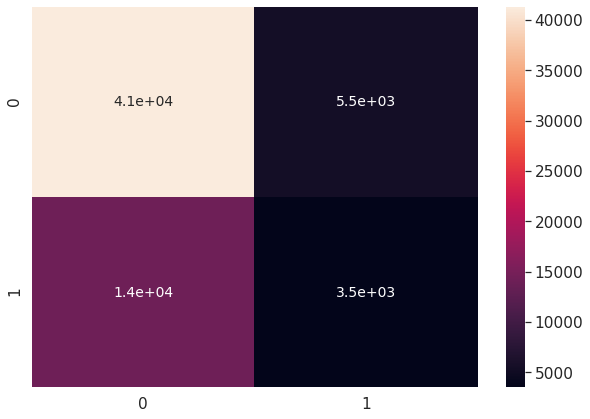

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_mat, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}) # font size


# |TN FN|
# |FP TP|
plt.show()

### Model #3 - LogReg (numerical) + weight balancing ratio + hyper parameter tuning 
- Features:
            ['DISTANCE', 'ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
             'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
             'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
             'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
             'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
             'AVG_SLP_DEST']


- Label:
            ['DEP_DEL15']

In [0]:
m3_cols = ['DISTANCE', 'CRS_ELAPSED_TIME','ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
       'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
       'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
       'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
       'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
       'AVG_SLP_DEST', 'DEP_DEL15']

m3_train = train.select(*m3_cols).withColumnRenamed('DEP_DEL15', 'label')
m3_test = test.select(*m3_cols).withColumnRenamed('DEP_DEL15', 'label')


In [0]:
balancing_ratio = m3_train.filter("label == 0").count() / m3_train.count()
m3_train = m3_train.withColumn("CLASS_WEIGHTS", when(m3_train.label == 1, balancing_ratio).otherwise(1 - balancing_ratio))

In [0]:
#Stages
vector_assembler = VectorAssembler(inputCols=m3_cols[:-1], outputCol="SS_features")
standard_scaler = StandardScaler(inputCol="SS_features", outputCol="features")
lr = LogisticRegression(weightCol="CLASS_WEIGHTS")

#Pipeline 
stages = [vector_assembler,standard_scaler, lr]
m3_pipeline = Pipeline().setStages(stages)


# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# This grid will have 7 x 2 x 7 x 3 = 294 parameter settings for CrossValidator to choose from.

# Hyper Parameter tuning
# Elastic regualarization, so that parameters don't over dominate to prevent overfitting (Combo of L1 + L2)
paramGrid = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.5, 0.3, 0.1, 0.05, 0.01, 0.005, 0.001]) \
            .addGrid(lr.fitIntercept, [False, True]) \
            .addGrid(lr.elasticNetParam, [0.5, 0.3, 0.1, 0.05, 0.01, 0.005, 0.001]) \
            .build()

crossval = CrossValidator(estimator=m3_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# #Elastic regualarization, so that parameters don't over dominate to prevent overfitting (Combo of L1 + L2)
# paramGrid = ParamGridBuilder() \
#             .addGrid(lr.regParam, [0.5, 0.1, 0.01]) \
#             .addGrid(lr.fitIntercept, [False, True]) \
#             .addGrid(lr.elasticNetParam, [0.5, 0.1, 0.01]) \
#             .build()

# crossval = CrossValidator(estimator=m3_pipeline,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=BinaryClassificationEvaluator(),
#                           numFolds=3)  # use 3+ folds in practice


# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(m3_train)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
m3_results = cvModel.transform(m3_test)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
#Save the model out in case we need to reference again in the future
cvModel.save("dbfs:/mnt/mids-w261/team20SSDK/models/logRegCV")

In [0]:
# cvModel.stages[-1].coefficients

cvModel.bestModel.stages

Out[209]: [VectorAssembler_79bfa784b51f,
 StandardScalerModel: uid=StandardScaler_efaa87627457, numFeatures=16, withMean=false, withStd=true,
 LogisticRegressionModel: uid=LogisticRegression_4cf7ab697051, numClasses=2, numFeatures=16]

In [0]:
bestModel = cvModel.bestModel
print("Best Param (regParam)", bestModel.__java_obj.getRegParam())
print("Best Param (elasticNetParam)", bestModel.__java_obj.getElasticNetParam())

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-2127515060495716> in <module> 
 1 bestModel = cvModel . bestModel
 ----> 2 print ( "Best Param (regParam)" , bestModel . __java_obj . getRegParam ( ) ) 
 3 print ( "Best Param (elasticNetParam)" , bestModel . __java_obj . getElasticNetParam ( ) ) 

 AttributeError : 'PipelineModel' object has no attribute '__java_obj'

In [0]:
predAndLabels = m3_results.select(col("prediction").alias("raw"),"label")

#Set up BinClassEval
evaluator = BinaryClassificationEvaluator()
evaluator.setRawPredictionCol("raw")

print("areaUnderPR: ", evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderPR"}))
print("areaUnderROC: ",evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderROC"}))

areaUnderPR: 0.3369416752805772
areaUnderROC: 0.5375727332734648

### Model #4 - LogReg (numerical) + weight balancing ratio + hyper parameter tuning + CV
- Features:
            ['DISTANCE', 'CRS_ELAPSED_TIME', 'ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
             'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
             'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
             'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
             'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
             'AVG_SLP_DEST']


- Label:
            ['DEP_DEL15']

In [0]:
m4_cols = ['DISTANCE', 'CRS_ELAPSED_TIME','ORIGIN_FLIGHT_COUNT', 'DEST_FLIGHT_COUNT', 'PAGERANK',
       'AVG_WND_SPEED_ORIGIN', 'MIN_CIG_HEIGHT_ORIGIN',
       'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
       'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'MIN_CIG_HEIGHT_DEST',
       'MIN_VIS_DIS_DEST', 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST',
       'AVG_SLP_DEST', 'DEP_DEL15']

m4_train = train.select(*m4_cols).withColumnRenamed('DEP_DEL15', 'label')
m4_test = test.select(*m4_cols).withColumnRenamed('DEP_DEL15', 'label')


In [0]:
balancing_ratio = m4_train.filter("label == 0").count() / m4_train.count()
m4_train = m4_train.withColumn("CLASS_WEIGHTS", when(m4_train.label == 1, balancing_ratio).otherwise(1 - balancing_ratio))

In [0]:
display(m4_train)

DISTANCE CRS_ELAPSED_TIME ORIGIN_FLIGHT_COUNT DEST_FLIGHT_COUNT PAGERANK AVG_WND_SPEED_ORIGIN MIN_CIG_HEIGHT_ORIGIN MIN_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN AVG_DEW_DEG_ORIGIN AVG_SLP_ORIGIN AVG_WND_SPEED_DEST MIN_CIG_HEIGHT_DEST MIN_VIS_DIS_DEST AVG_TMP_DEG_DEST AVG_DEW_DEG_DEST AVG_SLP_DEST label CLASS_WEIGHTS 534.0 105.0 1086 195 0.05425050648176137 30.5 1311 402 -16.75 -65.125 10274.5 29.09090909090909 22000 16093 -27.0 -119.81818181818181 10240.454545454546 1.0 0.7892039313371892 701.0 110.0 1086 13 0.05425050648176137 30.5 1311 402 -16.75 -65.125 10274.5 35.6875 22000 16093 -46.125 -116.0625 10214.125 1.0 0.7892039313371892 1440.0 228.0 936 506 0.04521768069470927 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 24.6 610 1609 -18.0 -46.4 10144.8 0.0 0.21079606866281075 925.0 175.0 936 585 0.04521768069470927 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 32.84615384615385 1280 12875 28.615384615384617 -23.076923076923077 10272.076923076924 0.0 0.21079606866281075 1182.0 188.0 936 333 0.04521768069470927 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 24.833333333333332 427 805 210.25 200.08333333333334 10210.166666666666 0.0 0.21079606866281075 888.0 167.0 936 706 0.04521768069470927 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 33.25 22000 16093 -144.625 -203.5 10234.875 0.0 0.21079606866281075 235.0 85.0 936 340 0.04521768069470927 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 62.705882352941174 914 16093 -71.82352941176471 -139.41176470588235 10199.35294117647 1.0 0.7892039313371892 867.0 136.0 936 345 0.04521768069470927 49.2962962962963 152 3219 -62.592592592592595 -109.77777777777777 10208.777777777777 39.733333333333334 1372 16093 -59.4 -140.46666666666667 10170.866666666667 0.0 0.21079606866281075 762.0 128.0 1086 357 0.05425050648176137 30.5 1311 402 -16.75 -65.125 10274.5 49.111111111111114 22000 16093 -43.22222222222222 -140.0 10194.777777777777 0.0 0.21079606866281075 689.0 136.0 1086 585 0.05425050648176137 30.5 1311 402 -16.75 -65.125 10274.5 32.84615384615385 1280 12875 28.615384615384617 -23.076923076923077 10272.076923076924 0.0 0.21079606866281075 404.0 87.0 1086 476 0.05425050648176137 31.4375 22000 402 -27.875 -69.875 10263.9375 37.22727272727273 61 4828 156.54545454545453 140.3181818181818 10233.363636363636 0.0 0.21079606866281075 733.0 124.0 936 357 0.04521768069470927 51.629629629629626 122 805 -61.48148148148148 -106.77777777777777 10201.444444444445 44.2 22000 16093 -45.0 -142.5 10198.7 0.0 0.21079606866281075 606.0 127.0 936 1086 0.04521768069470927 51.629629629629626 122 805 -61.48148148148148 -106.77777777777777 10201.444444444445 31.4375 22000 402 -27.875 -69.875 10263.9375 0.0 0.21079606866281075 594.0 112.0 1086 304 0.05425050648176137 31.4375 22000 402 -27.875 -69.875 10263.9375 25.7 183 6437 208.3 196.2 10214.8 0.0 0.21079606866281075 581.0 108.0 1086 333 0.05425050648176137 31.4375 22000 402 -27.875 -69.875 10263.9375 25.7 183 6437 208.3 196.2 10214.8 1.0 0.7892039313371892 226.0 72.0 1086 414 0.05425050648176137 31.4375 22000 402 -27.875 -69.875 10263.9375 23.25 22000 12875 -25.0 -54.75 10270.0 0.0 0.21079606866281075 1005.0 163.0 936 476 0.04521768069470927 51.629629629629626 122 805 -61.48148148148148 -106.77777777777777 10201.444444444445 37.22727272727273 61 4828 156.54545454545453 140.3181818181818 10233.363636363636 0.0 0.21079606866281075 222.0 66.0 936 6 0.04521768069470927 51.629629629629626 122 805 -61.48148148148148 -106.77777777777777 10201.444444444445 56.28 396 4023 -72.0 -129.28 10188.28 0.0 0.21079606866281075 1590.0 260.0 1086 347 0.05425050648176137 31.4375 22000 402 -27.875 -69.875 10263.9375 28.25 22000 14484 -137.75 -186.5 10250.75 0.0 0.21079606866281075 721.0 140.0 1086 184 0.05425050648176137 31.4375 22000 402 -27.875 -69.875 10263.9375 31.181818181818183 579 6437 -7.0 -49.227272

In [0]:
#Stages
vector_assembler = VectorAssembler(inputCols=m4_cols[:-1], outputCol="SS_features")
standard_scaler = StandardScaler(inputCol="SS_features", outputCol="features")
lr = LogisticRegression(weightCol="CLASS_WEIGHTS", maxIter=10, regParam= 1.0, elasticNetParam = 1.0)

#Pipeline 
stages = [vector_assembler,standard_scaler, lr]
m4_pipeline = Pipeline().setStages(stages)


m4_model = m4_pipeline.fit(m4_train) #Fit the pipeline on the training data
m4_results = m4_model.transform(m4_test) #transform the test set with the pipeline, don't want to fit on this.

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# This grid will have 7 x 2 x 7 x 3 = 294 parameter settings for CrossValidator to choose from.

# crossval = CrossValidator(estimator=m4_pipeline,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=BinaryClassificationEvaluator(),
#                           numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
# cvModel = crossval.fit(m4_train)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
# m4_results = cvModel.transform(m3_test)

In [0]:
m4_train_results = m4_model.transform(m4_train)
predAndLabels = m4_train_results.select(col("prediction").alias("raw"),"label")

#Set up BinClassEval
evaluator = BinaryClassificationEvaluator()
evaluator.setRawPredictionCol("raw")

print("areaUnderPR: ", evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderPR"}))
print("areaUnderROC: ",evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderROC"}))

areaUnderPR: 0.21079606866281075
areaUnderROC: 0.5

In [0]:
predAndLabels = m4_results.select(col("prediction").alias("raw"),"label")

#Set up BinClassEval
evaluator = BinaryClassificationEvaluator()
evaluator.setRawPredictionCol("raw")

print("areaUnderPR: ", evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderPR"}))
print("areaUnderROC: ",evaluator.evaluate(predAndLabels, {evaluator.metricName: "areaUnderROC"}))

areaUnderPR: 0.27481519363987167
areaUnderROC: 0.5

In [0]:
predLabels = predAndLabels.collect()
y_true = [x.label for x in predLabels]
y_pred = [x.raw for x in predLabels]
conf_mat = confusion_matrix(y_true, y_pred)

print("Accuracy Score: ", accuracy_score(y_true, y_pred))
print("F1 Score: ", f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy Score: 0.7115935964789933
F1 Score: 0.10295960667116552
 precision recall f1-score support

 0.0 0.73 0.96 0.83 46794
 1.0 0.35 0.06 0.10 17733

 accuracy 0.71 64527
 macro avg 0.54 0.51 0.47 64527
weighted avg 0.63 0.71 0.63 64527